In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

In [2]:
#need to replicate table 3?
school_data = pd.read_stata('aerdata_colombia2.dta')
#keep if checkid==1 & age>=9 & age<=25
school_data = school_data[(school_data['checkid']==1) &
                          (school_data['age']>=9) & (school_data['age']<=25) ]
print(school_data.describe())

            vouch0     sex_name      match_i     match_ic     match_i7  \
count  3542.000000  3542.000000  3542.000000  3542.000000  3542.000000   
mean      0.585263     0.494918     0.354037     0.338509     0.331451   
std       0.492746     0.500045     0.478288     0.473269     0.470801   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               age        phone  checkid         math         read  \
count  3542.000000  3542.000000   3542.0  3541.000000  3541.000000   
mean     12.670243     0.886222      1.0    14.713037    16.355835   
std       1.295708     0.317586      0.0    20.436213    22.758410   
min      10.000000     0.000000      1.0     0.000000

(array([143., 110., 256., 230., 168.,  64.,  74.,  36.,   6.,   4.]),
 array([41. , 43.3, 45.6, 47.9, 50.2, 52.5, 54.8, 57.1, 59.4, 61.7, 64. ],
       dtype=float32),
 <a list of 10 Patch objects>)

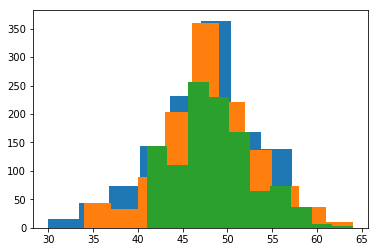

In [3]:
plt.hist(school_data['read'][school_data['read']>0])

cutoff = stats.mode(school_data['readcens1'])[0][0]
plt.hist(school_data['readcens1'][school_data['readcens1']>cutoff])

cutoff = stats.mode(school_data['readcens10'])[0][0]
plt.hist(school_data['readcens10'][school_data['readcens10']>cutoff])

In [4]:
# Fit the model with ols = True
x_names =['vouch0', 'age', 'sex_name'] 
y_name = 'readcens10'
#different datasets
cutoff = stats.mode(school_data[y_name])[0][0]
school_nozeros = school_data[ (school_data[y_name]> cutoff) ]


#setup x/y for missing data models
x = sm.add_constant(school_nozeros[x_names].copy())
y = school_nozeros[y_name]

ols_model = sm.OLS(y,x).fit()
print(ols_model.summary())

#setup x/y for missing data models
x = school_data[x_names].copy()
y = school_data[y_name]

x = sm.add_constant(x[~np.isnan(y)])
y = y[~np.isnan(y)]

                            OLS Regression Results                            
Dep. Variable:                   read   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     11.42
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           2.19e-07
Time:                        16:31:18   Log-Likelihood:                -3822.3
No. Observations:                1223   AIC:                             7653.
Df Residuals:                    1219   BIC:                             7673.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.3987      2.391     24.421      0.0

/home/erichschulman/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 1.146240
         Iterations: 102
         Function evaluations: 173


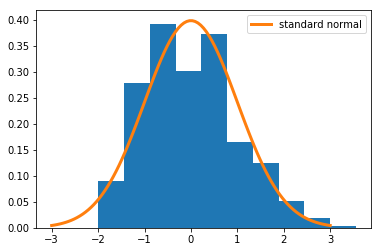

In [51]:
cc_model = selection_tests.Tobit(y,x, cc=True)
cc_fit  = cc_model.fit()

#why is there randomly a missing observation?
#print(cc_model.summary(title='OLS CC').as_latex())

cc_resid = cc_model.resid(cc_fit.params)
plt.hist(cc_resid[cc_resid != 0]/np.sqrt(cc_fit.params[-1]),density=True)
norm_x = np.linspace(-3, 3, 100)
plt.plot(norm_x, stats.norm.pdf(norm_x, 0,1),linewidth=3,label='standard normal')
plt.legend()
plt.show()

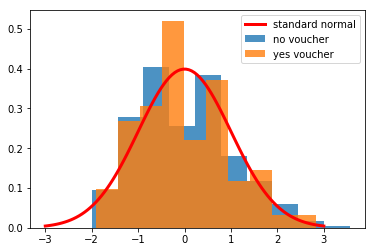

In [49]:
cc_resid = cc_model.resid(cc_fit.params)
plt.hist(cc_resid[ (cc_resid != 0) & (x['vouch0']==1) ]/np.sqrt(cc_fit.params[-1]),density=True,
         alpha=.8,label='no voucher')
plt.hist(cc_resid[ (cc_resid != 0) & (x['vouch0']==0) ]/np.sqrt(cc_fit.params[-1]),density=True,
         alpha=.8,label='yes voucher')
norm_x = np.linspace(-3, 3, 100)
plt.plot(norm_x, stats.norm.pdf(norm_x, 0,1),linewidth=3,label='standard normal',color='red')
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 1.442082
         Iterations: 477
         Function evaluations: 763
[102.77230457   2.05882076  -5.50070892  -0.71779137 104.30727111]


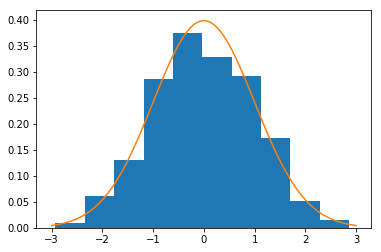

In [44]:
# Fit the model with ols = False
tobit_model = selection_tests.Tobit(y,x)
tobit_fit  = tobit_model.fit()
print(tobit_fit.params)

#why is there randomly a missing observation?
#print(tobit_fit.summary(title='Tobit').as_latex())

tobit_resid = tobit_model.resid(tobit_fit.params)
tobit_resid  = tobit_resid[tobit_resid!=0]
plt.hist( (tobit_resid - tobit_resid.mean() )/np.sqrt( tobit_resid.var()),
         density=True)
norm_x = np.linspace(-3, 3, 100)
plt.plot(norm_x, stats.norm.pdf(norm_x, 0,1))

48.80110168457031
48.265506744384766
4.419184684753418


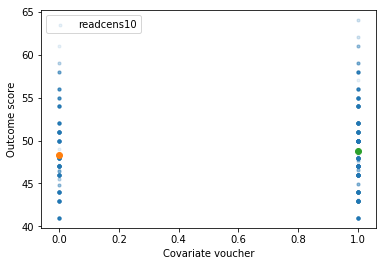

In [7]:
#create plot for true
plt.scatter(school_nozeros['vouch0'], school_nozeros[y_name],marker='.',alpha=.1)
for i in [0,1]:
    plt.scatter(i, school_nozeros[y_name][school_nozeros['vouch0']==i].mean(),alpha=1)
#support_x = np.arange(xn.min(),xn.max(),.05)
print(school_nozeros[y_name][school_nozeros['vouch0']==1].mean())
print(school_nozeros[y_name][school_nozeros['vouch0']==0].mean())
print(school_nozeros[y_name].std())
#tobit
#pr_obs_1 = stats.norm.cdf( model1_fit.params[0]+model1_fit.params[1]*support_x)
#plt.plot(support_x, (model1_fit.params[0] + model1_fit.params[1]*support_x)*pr_obs_1 ,label="tobit",
#         color='green',linestyle='--')

#ols
#plt.plot(support_x, model2_fit.params[0] + model2_fit.params[1]*support_x ,label="ols",
#         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome score")
plt.xlabel("Covariate voucher")
plt.legend()
#plt.savefig('../figs/tobit_%s.png'%int(beta1*100))
plt.show()

48.80110168457031
48.265506744384766


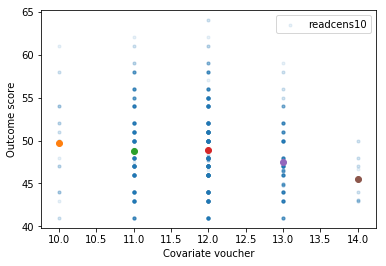

In [9]:
#create plot for true
plt.scatter(school_nozeros['age'], school_nozeros[y_name],marker='.',alpha=.1)
for i in [10,11,12,13,14]:
    plt.scatter(i, school_nozeros[y_name][school_nozeros['age']==i].mean(),alpha=1)
#plt.scatter(1, school_nozeros[y_name][school_nozeros['vouch0']==1].mean(),alpha=1)
#support_x = np.arange(xn.min(),xn.max(),.05)
print(school_nozeros[y_name][school_nozeros['vouch0']==1].mean())
print(school_nozeros[y_name][school_nozeros['vouch0']==0].mean())


#create plot for normal
plt.ylabel("Outcome score")
plt.xlabel("Covariate voucher")
plt.legend()
#plt.savefig('../figs/tobit_%s.png'%int(beta1*100))
plt.show()

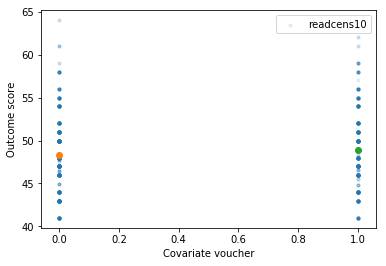

In [54]:
#create plot for true
plt.scatter(school_nozeros['sex_name'], school_nozeros[y_name],marker='.',alpha=.1)
for i in [0,1]:
    plt.scatter(i, school_nozeros[y_name][school_nozeros['sex_name']==i].mean(),alpha=1)
#plt.scatter(1, school_nozeros[y_name][school_nozeros['vouch0']==1].mean(),alpha=1)
#support_x = np.arange(xn.min(),xn.max(),.05)



#create plot for normal
plt.ylabel("Outcome score")
plt.xlabel("Covariate voucher")
plt.legend()
#plt.savefig('../figs/tobit_%s.png'%int(beta1*100))
plt.show()